In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from lib import plot_util
import pandas as pd
import dowhy
from dowhy import CausalModel

import importlib

sns.set_theme()
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Identify Estimands

## Build Graph

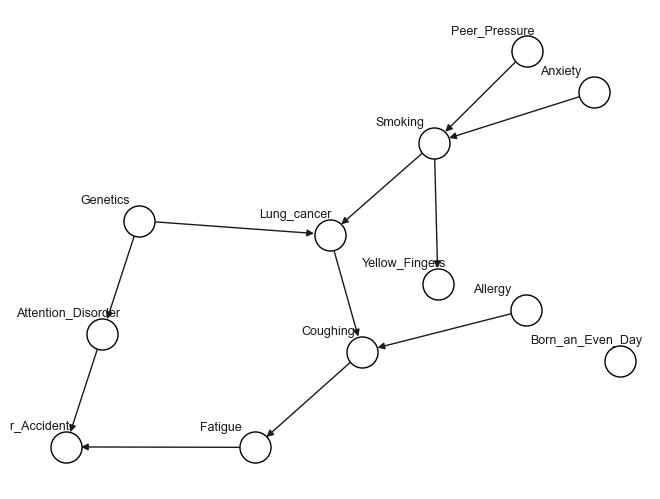

In [86]:
# import data
df_lucas0 = pd.read_csv("lucas0_train.csv")
nodes = df_lucas0.columns.values

# we import networkx and create a directed graph
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(
    [('Anxiety', 'Smoking'), ('Peer_Pressure', 'Smoking'), ('Smoking', 'Yellow_Fingers'),
     ('Smoking', 'Lung_cancer'), ('Lung_cancer', 'Coughing'), ('Allergy', 'Coughing'), ('Coughing', 'Fatigue'),
     ('Fatigue', 'Car_Accident'), ('Attention_Disorder', 'Car_Accident'), ('Genetics', 'Attention_Disorder'),
     ('Genetics', 'Lung_cancer')])

pos = nx.kamada_kawai_layout(G)
pos = {
    **pos,
    "Born_an_Even_Day": [0.9, -0.5],
    "Yellow_Fingers": [pos["Yellow_Fingers"][0] + 0.2, pos["Yellow_Fingers"][1] - 0.2],
    "Anxiety": [pos["Anxiety"][0] + 0.2, pos["Anxiety"][1] - 0.2],
}
pos_labels = plot_util.nudge(pos, -0.1, 0.1)
nx.draw(G, pos=pos, node_size=500, node_color='w', edgecolors='black')
nx.draw_networkx_labels(G, pos=pos_labels, font_size=9, font_weight=10)
nx.write_gml(G, "lucas0_backdoor_criterion_graph.gml")

In [87]:
import dowhy
from dowhy import CausalModel

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

gml_graph = gml_to_string('lucas0_backdoor_criterion_graph.gml')
# With GML string
model=CausalModel(
        data = df_lucas0,
        treatment='Yellow_Fingers',
        outcome='Lung_cancer',
        graph=gml_graph
        )

In [88]:
identified_estimand = model.identify_effect()
print(identified_estimand)

No directed path from ['Yellow_Fingers'] to ['Lung_cancer'] in the causal graph.
Causal effect is zero.


In [91]:
identifier = model.identifier
identifier.identify_backdoor(model._graph, model._treatment, model._outcome)

[{'backdoor_set': ('Car_Accident',
   'Peer_Pressure',
   'Anxiety',
   'Attention_Disorder',
   'Fatigue',
   'Smoking',
   'Genetics',
   'Coughing')},
 {'backdoor_set': ('Smoking',)}]